构建数据集

In [48]:
from dataclasses import dataclass
from transformers import LlavaProcessor, AutoProcessor
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Union

In [49]:
# 数据集
data_dir = '/sda1/llava_cc3m'
chat_file = Path(data_dir).joinpath('chat.json')
chat_data = pd.read_json(chat_file)
chat_data.head(10)

,id,image,conversations
0,GCC_train_002582585,GCC_train_002582585.jpg,"[{'from': 'human', 'value': 'Provide a brief d..."
1,GCC_train_002429825,GCC_train_002429825.jpg,"[{'from': 'human', 'value': '<image> Write a t..."
2,GCC_train_000190697,GCC_train_000190697.jpg,"[{'from': 'human', 'value': 'Share a concise i..."
3,GCC_train_002503829,GCC_train_002503829.jpg,"[{'from': 'human', 'value': 'Relay a brief, cl..."
4,GCC_train_000530863,GCC_train_000530863.jpg,"[{'from': 'human', 'value': '<image> Render a ..."
5,GCC_train_001970366,GCC_train_001970366.jpg,"[{'from': 'human', 'value': 'Create a compact ..."
6,GCC_train_001885390,GCC_train_001885390.jpg,"[{'from': 'human', 'value': '<image> Render a ..."
7,GCC_train_001764002,GCC_train_001764002.jpg,"[{'from': 'human', 'value': '<image> Give a sh..."
8,GCC_train_002554598,GCC_train_002554598.jpg,"[{'from': 'human', 'value': 'Create a compact ..."
9,GCC_train_001948583,GCC_train_001948583.jpg,"[{'from': 'human', 'value': '<image> Summarize..."


In [50]:
image_dir = Path(data_dir).joinpath('images_dl')
image_dir

PosixPath('/sda1/llava_cc3m/images_dl')

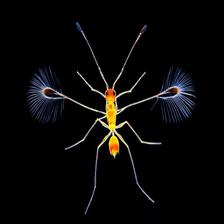

In [51]:
# 测试图片
test_chat = chat_data.iloc[100]
test_image = image_dir.joinpath(test_chat['image'])
Image.open(test_image)

In [52]:
#测试Q&A
q = test_chat['conversations'][0]['value']
a = test_chat['conversations'][1]['value']
print(
    f"Question:{q}\nAnswer:{a}"
)

Question:Relay a brief, clear account of the picture shown.
<image>
Answer:at millimeters long , this fairy - fly wasp may be one of the smallest insects in the world


In [53]:
# 我们需要一个Dataset类, 可以自动加载出索引对应的文本数据和图像的路径
class LlavaDataset(Dataset):
    
    def __init__(self, data_dir:str) -> None:
        super().__init__()
        self.chat_data, self.image_dir = self.build_dataset(data_dir)
    
    def build_dataset(self, data_dir:str) -> Tuple[List[Dict], Path]:
        """
        从dataset_dir中构建数据集, 返回 chat_data:Dict['conversations', 'image'] 和图片的路径
        """
        data_dir = Path(data_dir)
        chat_dir = data_dir.joinpath('chat.json')
        chat_data = pd.read_json(chat_dir).to_dict(orient='records')
        image_dir = data_dir.joinpath('images_dl')
        
        return chat_data, image_dir
        
    def __len__(self):
        return len(chat_data)
    
    def __getitem__(self, index) -> Tuple[any, any, Path]:
        cur_data = self.chat_data[index]
        question = cur_data['conversations'][0]['value']
        answer = cur_data['conversations'][1]['value']
        image_path = self.image_dir.joinpath(cur_data['image'])
        return question, answer, image_path
   
test_llava_dataset = LlavaDataset(data_dir)  

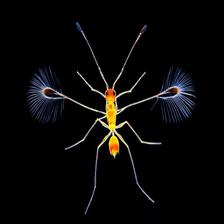

In [54]:
q, a, image = test_llava_dataset[100]
Image.open(image)

In [66]:
template = (
    "{% for message in messages %}"
        "{% if message['role'] == 'system' %}"
            "{{ message['content'] }}\n"  
        "{% elif message['role'] == 'user' %}"
            "{{ 'USER: ' }}"                
            "{{ message['content'] }}\n"  
        "{% elif message['role'] == 'assistant' %}"
            "{{ 'ASSISTANT: ' }}"        
            "{{ message['content'] }}\n"  
        "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"     
        "{{ 'ASSISTANT:' }}"             
    "{% endif %}"
)

In [67]:
@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    a_input_ids: torch.Tensor
    pixel_values: torch.Tensor

def build_qaimage(processor: LlavaProcessor, question: str, answer: str, image_path: str) -> QaImageOutput:
    """ 
    接收dataset的单个样本(question, answer, image_path), 
    生成prompt, 打开图像, 用prosessor处理, 
    同时将答案文本转换成 input_ids, 返回封装的QaImageOutput对象
    """
        
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": question},
    ]
    
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True, chat_template=template
    )
    
    raw_image = Image.open(image_path)

    inputs = processor(raw_image, prompt, return_tensors='pt')
    
    answer_ids = processor.tokenizer(
        answer,
        return_tensors='pt',
        padding='longest',
    )['input_ids']
    
    return QaImageOutput(
        q_input_ids=inputs['input_ids'],
        a_input_ids=answer_ids,
        pixel_values=inputs['pixel_values']
    )



In [68]:

model_name_or_path = '/sda1/llava-7b-hf'

processor = AutoProcessor.from_pretrained(
    pretrained_model_name_or_path=model_name_or_path,
    trust_remote_code=True,
    local_files_only=True,
    )
q, a, image = test_llava_dataset[100]



In [69]:
qa = build_qaimage(processor, q, a, image)
print(processor.tokenizer.decode(qa.q_input_ids[0]))

<s> You are a helpful assistant.
USER: Relay a brief, clear account of the picture shown.
<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image>

In [70]:
class LlavaCollator:
    def __init__(self, processor: LlavaProcessor, IGNORE_INDEX: int) -> None:
        self.processor = processor
        self.IGNORE_INDEX = IGNORE_INDEX
        
    def convert_one_piece(
        self, qa: QaImageOutput
    ) -> Dict[str, torch.Tensor]:
        """ 将单个QAImageOutput转换成模型输入, 注意这里的labels需要忽略question部分 """
        # 将输入数据转换成模型输入
        pixel_values = qa.pixel_values #[1, 3, 224, 224]
        input_ids = None
        a_input_ids = qa.a_input_ids #[1, 20]
        q_input_ids = qa.q_input_ids #[1, 15]
        q_ignore = torch.full_like(q_input_ids, self.IGNORE_INDEX)
        labels = torch.cat(
            [
                q_ignore, 
                a_input_ids, 
                torch.tensor(processor.tokenizer.eos_token_id).reshape(-1, 1)
                ], 
            dim=1 # [1, 35]
        )
        input_ids = torch.cat(
            [
                q_input_ids, 
                a_input_ids, 
                torch.tensor(processor.tokenizer.eos_token_id).reshape(-1, 1)
                ], 
            dim=1
        )
        return input_ids, labels, pixel_values
    
    # 目的: collator([[dataset[0], [dataset[1]], ...]) -> batch
    def __call__(self, features: List) -> Dict[str, torch.Tensor]:
        """ 
        将batch中的所有样本转换成模型输入, 
        注意这里的labels需要忽略question部分 
        """
        input_ids_list = []
        labels_list = []
        len_list = []
        pixel_values_list = []
        for feature in features:
            qa = build_qaimage(
                self.processor,
                feature[0],
                feature[1],
                feature[2]
            )
            input_ids, labels, pixel_values = self.convert_one_piece(qa)
            
            print(f"解码后的 input_ids: {self.processor.tokenizer.decode(input_ids[0])}") # [0] 是因为 input_ids 是 [1, seq_len]
            # 计算图像标记ID的出现次数
            # 假设你的 processor.tokenizer.image_token 是图像标记的字符串形式
            image_token_id = self.processor.tokenizer.convert_tokens_to_ids(self.processor.tokenizer.image_token)
            # 或者如果你的processor有直接的 image_token_id 属性：
            # image_token_id = self.processor.image_token_id
            num_image_tokens = (input_ids[0] == image_token_id).sum().item()
            print(f"input_ids 中的图像标记数量: {num_image_tokens}")
            
            input_ids_list.append(input_ids)
            labels_list.append(labels)
            pixel_values_list.append(pixel_values)
            len_list.append(input_ids.shape[1])
        # padding
        max_len = max(len_list)
        
        # 每个样本需要填充的长度是 max_len - len[i]
        # input_ids 填充 pad_id(不计算注意力), labels 填充 IGNORE_INDEX(不计算损失)
        final_input_ids = torch.concat(
            [
                torch.concat(
                    [torch.full((1, max_len - len_list[index]), 
                           self.processor.tokenizer.pad_token_id),
                    value], dim=1 # [1, max_len]
                    )
                for index, value in enumerate(input_ids_list)
            ], dim = 0 # [batch_size, max_len]
        )
        
        final_labels = torch.concat(
            [
                torch.concat(
                    [torch.full((1, max_len - len_list[index]), 
                           self.IGNORE_INDEX),
                    value], dim=1 
                    )
                for index, value in enumerate(labels_list)
            ], dim=0 
        )
        
        final_pixel_values = torch.concat(
            pixel_values_list, dim=0
        )
        
        attention_mask = torch.concat(
            [
                torch.concat(
                    [torch.zeros(1, max_len - length, dtype=torch.long),
                    torch.ones((1, length), dtype=torch.long)], dim=1) 
                for length in len_list
            ], dim=0
        )
        
        
        return {
            'input_ids': final_input_ids,
            'labels': final_labels,
            'pixel_values': final_pixel_values,
            'attention_mask': attention_mask
        }
        

In [71]:

test_collator = LlavaCollator(processor, IGNORE_INDEX=-100)
result = test_collator(
    [

        test_llava_dataset[20],
    ]
)
result['attention_mask']

解码后的 input_ids: <s> You are a helpful assistant.
USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image>

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [63]:
# 加载模型
from transformers import LlavaForConditionalGeneration
model_name_or_path = '/sda1/llava-7b-hf'
model = LlavaForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=model_name_or_path,
    trust_remote_code=True,
    local_files_only=True,
    device_map='auto',
)


Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


In [72]:
for key in result.keys():
    print(key, result[key].shape)
    result[key] = result[key].to(model.device)

input_ids torch.Size([1, 620])
labels torch.Size([1, 620])
pixel_values torch.Size([1, 3, 336, 336])
attention_mask torch.Size([1, 620])


In [73]:
model(**result)

LlavaCausalLMOutputWithPast(loss=tensor(6.2171, device='cuda:0', grad_fn=<ToCopyBackward0>), logits=tensor([[[  1.4071,   0.7952,  -0.3502,  ...,   0.5492,   0.5503,   0.5589],
         [ -6.3189,  -3.9090,   5.9607,  ...,  -0.0496,  -0.0362,  -0.0340],
         [ -3.9348,   0.9721,   7.6535,  ...,   0.0196,   0.0300,   0.0363],
         ...,
         [ -5.3765,  -9.1051,   4.2787,  ...,  -0.1519,  -0.1364,  -0.1380],
         [ -7.8230, -10.1166,   7.7408,  ...,   0.2536,   0.2609,   0.2588],
         [ -3.7795,   2.0989,   5.2253,  ...,   0.2488,   0.2489,   0.2465]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x7f38d148b4d0>, hidden_states=None, attentions=None, image_hidden_states=tensor([[[-0.0979, -0.0800, -0.6398,  ..., -0.4686,  0.5800, -0.7865],
         [ 0.2087,  0.2336, -0.6673,  ..., -0.2618,  0.1413, -0.6451],
         [ 0.0013,  0.3646, -0.1857,  ..., -0.1999,  0.1051, -0.2800],
         ...,
    

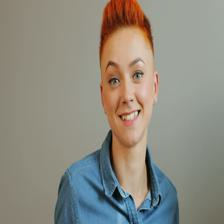

In [2]:
from PIL import Image
Image.open('/sda1/llava_cc3m/images_dl/GCC_train_002498375.jpg')